## Data Centric ML Development using Snowflake and Amazon SageMaker

This notebook guides you through a Data Centric machine learning (ML) development process using Snowflake and Amazon SageMaker. We demonstrate the use case through a credit-risk analysis use case.

**What you will learn:**

* How to use the Snowflake connector for Amazon SageMaker DataWrangler.
* How to train a model using a AWS Marketplace algorithm, Autogluon.
* How to enrich your ML dataset with data from the Snowflake Data Marketplace.
* How to iterate on your model design and data prep flows with the provided tools.
* How to deploy a production scoring pipeline.

**How to run it:**

This notebook was designed for Amazon SageMaker Studio, and to run on the Snowflake kernel that has been customized for this workshop. CloudFormation [templates](https://github.com/dylan-tong-aws/snowflake-sagemaker-workshops) have been provided for you to setup the workshop environment including the creation of the Snowflake SageMaker kernel.

Refer to this [DockerFile](https://github.com/aws-samples/amazon-sagemaker-kernel-builder/blob/main/kernels/snowflake/Dockerfile) if you like to know what dependencies are baked into the kernel. The kernel is created and integrated using the [Amazon SageMaker Studio Kernel Builder solution](https://github.com/aws-samples/amazon-sagemaker-kernel-builder)

**Have feedback?** <br>
Contact: [Dylan Tong](mailto:dylatong@amazon.com)


---
### Pre-requisites

1. **Setup Environment** using the provided CloudFormation [templates](https://github.com/dylan-tong-aws/snowflake-sagemaker-workshops). You can use the following launch button if you haven't completed this step yet.

    <a href="https://console.aws.amazon.com/cloudformation/home?region=region#/stacks/new?stackName=snowflake-sagemaker-credit-risk-workshop&templateURL=https://dtong-public-fileshare.s3.us-west-2.amazonaws.com/snowflake-sagemaker-workshop/src/deploy/cf/workshop-setup-no-studio.yml"/> ![Existing SageMaker Studio Environment](./images/deploy-to-aws.png) 
    
    The button above will launch a CloudFormation template that creates IAM permissions and a custom Amazon SageMaker Studio Kernel that has additonal dependencies like the Snowflake Python Connector pre-installed. The template automates a lot of functionality to simplify this workshop. You need to relog into Amazon SageMaker Studio to see the "snowflake-workshop" kernel.
    
    If you are running this lab with an existing Amazon SageMaker Studio environment, you should ensure that you're running the **latest versions of Amazon SageMaker Studio and DataWrangler**. This involves restarting the applications to force an upgrade. Follow the instructions provided in the **[documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-tasks-update.html)**.

2. If you haven't created a [Storage Integration](https://docs.snowflake.com/en/sql-reference/sql/create-storage-integration.html) resource in Snowflake yet you can click the button below to use a CloudFormation template to do so.

    <a href="https://console.aws.amazon.com/cloudformation/home?region=region#/stacks/new?stackName=VHOLSM&templateURL=https://snowflake-corp-se-workshop.s3.us-west-1.amazonaws.com/VHOL_Snowflake_Data_Wrangler/V2/cft/createstorageintegration.yml"/> ![Snowflake Storage Integration](./images/deploy-to-aws.png) 
     
     Make sure to only use UPPERCASE letters and digits with no space or dahses for the Stack Name, as this will be used to name the Storage Integration.


3. Run the following cells to import the required libraries and set the global variables. Make sure that your notebook is running in the "snowflake-workshop" kernel environment.

   <img src="./images/snowflake-kernel.png" align="left" width="70%"/>

In [1]:
import pandas as pd
from IPython.display import Markdown as md

import boto3
import sagemaker
from sagemaker.s3 import S3Uploader
from sagemaker import get_execution_role
from sagemaker import AlgorithmEstimator, get_execution_role

import utils.algo
import utils.dw
from workflow.pipeline import BlueprintFactory
from utils.trust import ModelInspector

sess = sagemaker.Session()
role = get_execution_role()
region     = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket     = f"snowflake-sagemaker-{account_id}-{initials}"


### Step 1: Configure Permissions
---

#### 1.1 Provide Snowflake Access to External Stage

You have already associated your Snowflake storage integration to an IAM role. We need to configure that IAM role with the proper trust policy, so that Snowflake can write data into the external stage. **Run the following cell** to generate a direct link to the IAM role.  
    
A placeholder trust policy was created by the CloudFormation template. It looks as follows:

            {
              "Version": "2012-10-17",
              "Statement": [
                {
                  "Effect": "Allow",
                  "Principal": {
                    "AWS": "arn:aws:iam::YOUR_ACCOUNT_ID:root"
                  },
                  "Action": "sts:AssumeRole",
                  "Condition": {
                    "StringEquals": {
                      "sts:ExternalId": "RUN_DESC_INTEGRATION_TO_GET_EXTERNALID"
                    }
                  }
                }
              ]
            }

    
Update the policy with property values that you obtained from the DESC INTEGRATION command.
    
    - Replace "arn:aws:iam::YOUR_ACCOUNT_ID:root" with the value obtained for STORAGE_AWS_IAM_USER_ARN
    - Replace "RUN_DESC_INTEGRATION_TO_GET_EXTERNALID" with the value obtained for STORAGE_AWS_EXTERNAL_ID

Proceed by following the generated link.

In [2]:
iam_trust_url = f"https://console.aws.amazon.com/iam/home?#/roles/snowflake-datawrangler-role-{region}?section=trust"
md(f"IAM console redirect: {iam_trust_url}")

IAM console redirect: https://console.aws.amazon.com/iam/home?#/roles/snowflake-datawrangler-role-us-west-2?section=trust

---
#### 1.2 Provide Access to [AWS Secrets Manager](https://aws.amazon.com/secrets-manager/)

Later in this lab, you will need to provide database credentials. We need to provide your Amazon SageMaker Studio environment permission to access AWS Secrets Manager so that the credentials are stored securely. 

We do this by **attaching the [SecretsManagerReadWrite](https://console.aws.amazon.com/iam/home?#/policies/arn:aws:iam::aws:policy/SecretsManagerReadWrite$jsonEditor) managed policy** to your Amazon SageMaker Studio's execution role. The authentication method used in this lab requires your Amazon SageMaker environment to have access to [AWS Secrets Manager](https://aws.amazon.com/secrets-manager/). If you provisioned this Amazon SageMaker Studio environment using the provided CloudFormation templates, this step has already been done for you.

If not, run the following cell to generate a direct link to the IAM role and attach the managed policy. Your execution role should look like the following:



<img src="./images/secret-manager-policy.png" align="left" width="65%"/>



In [3]:
rolename = get_execution_role().split("/")[-1]
exec_role_url = f"https://console.aws.amazon.com/iam/home?#/roles/{rolename}"
md(f"IAM console redirect: {exec_role_url}")

IAM console redirect: https://console.aws.amazon.com/iam/home?#/roles/cf-sm-studio-role-us-west-2

### Step 2: Build your Data Prep Flow
---

Next, we'll use the Snowflake connector for Data Wrangler to access our data and describe a pipeline that prepares our data for machine learning (ML) training. 

#### 2.1 Create a new Data Wrangler Flow

<img src="./images/create-data-flow.png" width=30% align="left" img/>


---
#### 2.2. Create a Snowflake Connection

Select Snowflake from the data source dropdown. </br>

<img src="./images/create-snowflake-connection.png" width=75% align="left" img/>


Configure the connection with information about your account and storage integration. </br>

Use the Storage Integration name identified in the Snowflake worksheet. 
You can use the Snowflake username and password, or you can use the AWS Secret that was created by the Snowflake Storage Integration CloudFormation Template. Copy the Secret ARN to paste in from the [Secrets Manager Console](https://console.aws.amazon.com/secretsmanager/home). </br>


<img src="./images/configure-snowflake-connection.png" width=45% align="left" img/>

---
#### 2.3 Explore your Snowflake Data

1. Select your data warehouse, database and schema. 
2. Run SELECT * FROM ML_LENDER_DATA.ML_DATA.LOAN_DATA_ML. The data set will be sampled by default.

This data set consists of a year of loan data from the [LendingClub](https://www.lendingclub.com/). It has been augmented with unemployment rate data provided by [Knoema](https://knoema.com/) from the [Snowflake Data Marketplace](https://www.snowflake.com/data-marketplace/). In this lab, we will demonstrate the data centric approach to improving machine learning model by showing how data from the Snowflake Marketplace can improve prediction performance. 

<img src="./images/query-and-explore-snowflake.png" width=80% align="left" img/>




---
#### 2.4 Refine your Features

With a bit of intuition and experience, you should be able to quickly spot some data columns that are unlikely to be good features. For instance, **LOAN_ID** is the unique identifier, and intuitively, we know that it has no meaningful correlation with loan defaults. On the other hand, **LOAN_AMNT** (*loan amount*) and **GRADE**, has potential. Large loans might bear greater risk. Similarly, we expect Grade F loans be riskier than Grade A ones. Thus, the former would help predict defaults. The machine learning algorithms can learn from these patterns and build a model that can predict the risk of defaults.

**Run** the following query to acquire a filtered list of potential features. Next, click the **Import** button and name your training dataset. 

Note: 
- You also have the alternative option to drop columns as part of your DataWrangler data prep flow.
- We're using Snowflake's sampling functionality to create a train/test set split. This query generates a repeatable 80% sampling of our data.

**SELECT** </br>
   >LOAN_ID, </br>
    LOAN_AMNT, </br> 
    FUNDED_AMNT, </br>
    TERM, </br>
    INT_RATE, </br>
    INSTALLMENT, </br>
    GRADE, </br>
    SUB_GRADE, </br>
    EMP_LENGTH, </br>
    HOME_OWNERSHIP, </br>
    ANNUAL_INC, </br>
    VERIFICATION_STATUS, </br>
    PYMNT_PLAN, </br>
    PURPOSE, </br>
    ZIP_SCODE, </br>
    DTI, </br>
    DELINQ_2YRS, </br>
    EARLIEST_CR_LINE, </br>
    INQ_LAST_6MON, </br>
    MNTHS_SINCE_LAST_DELINQ, </br>
    MNTHS_SINCE_LAST_RECORD, </br>
    OPEN_ACC, </br>
    PUB_REC, </br>
    REVOL_BAL, </br>
    REVOL_UTIL, </br>
    TOTAL_ACC, </br>
    INITIAL_LIST_STATUS, </br>
    MTHS_SINCE_LAST_MAJOR_DEROG, </br>
    POLICY_CODE, </br>
    LOAN_DEFAULT, </br>
    ISSUE_MONTH </br>
    
**FROM** ML_LENDER_DATA.ML_DATA.LOAN_DATA_ML </br>
sample block (80) REPEATABLE(100)

---
#### 2.5 Profile your Data

Data profiling and analysis is often a good place to start before you begin building your data preparation flow. Follow the steps illustrated by the video to create a histogram to analyze the distribution of loan defaults. **LOAN_DEFAULT** is the feature to plot.

![Loan Default Distribution](./images/create-histogram.gif)


Typical of loan default data, the dataset is skew. There are less default cases than successful ones. Our analysis helps us confirm that the skew is manageable. An AutoML algorithm will apply the appropriate mitigation techniques for us.

---
#### 2.6 Apply Feature Transforms

There are features that require transformations before the data can be trained. Later on, you will use an AutoML algorithm to train a model. The algorithm automates a great deal of feature engineering. Nonetheless, there is some data preparation that cannot be automated. We will go through the exercise of using SageMaker DataWrangler to transform the **INT_RATE** column. 

First, select the tail of the flow and select **Add transform**. </br>

</br>

<img src=./images/create-transform.png width="60%" align="left"/>






**INT_RATE** is an example of column that requires human input to properly process. This column is stored as a string type. ML algorithms only on numerical data. AutoML algorithms typically provide automation. They will detect string type columns and convert them accordingly. However, generally, they will assume that this column is categorical and apply [one-hot encoding](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-transform.html#data-wrangler-transform-cat-encode). This is the incorrect transformation and will render this feature useless. Instead, this feature should be treated as a continuous numerical feature. 

**TERM**, on the other hand, is seemingly similar but it could be left as a string. The dataset consists of 36 and 60 month terms. If you leave it as is, an AutoML algorithm will automically one-hot encode this column.

Use the **"Search and Edit"** transform to remove the "%" sign from **INT_RATE** so that we can convert the column into numerical values.

</br>

<img src=./images/ft-search-replace.png width="70%" align="left"/>

</br>

Next, use the **"Parse column as type"** to convert the data column from **String** to **Float**.


<img src=./images/ft-parse-type.png width="70%" align="left"/>

---

The **VERIFICATION_STATUS** column has a minor data quality issue. This feature is effectively a boolean, but the verified status is represented as two values. This transformation requires custom logic. In such cases, we can run a custom script using a **Custom Transform**. 

Copy the following PySpark script:

    from pyspark.sql.functions import udf
    from pyspark.sql.types import LongType

    def categories(status) : 
      if not status :
        return None
      elif status == "not verified" :    
        return 0
      elif status == "VERIFIED - income":
        return 1
      elif status == "VERIFIED - income source":
        return 1
      else :
        return None

    bucket_udf = udf(categories, LongType()) 
    df = df.withColumn("VERFIED", bucket_udf("VERIFICATION_STATUS"))

Apply the script by creating a **Custom Transform** as shown below:

<img src=./images/ft-custom-transform.png width="65%" align="left"/>


Since we created a new column we need to delete the source. Select **Manage columns** and apply the following settings:

**Transform:** Drop column </br>
**Column to Drop:** VERIFICATION_STATUS </br>


<img src=./images/drop-column-vstatus.png width="65%" align="left"/>

---

Finally, drop the **LOAN_ID** column. This is a unique identifier for each loan. It will only add noise to the training data. Select **Manage columns** and apply the following settings:

**Transform:** Drop column </br>
**Column to Drop:** LOAN_ID </br>

<img src="images/ft-drop-loanid.png" width="35%" align="left"/>

---

Click on **"back to data flow"**. You should see the five transforms steps at the tail of your data prep flow. 

<img src=./images/flow-w-transforms.png width="65%" align="left"/>

---
#### 2.7 Data Validation

It is best practice to perform data validation before model training. DataWrangler provides useful reports to faciliate data bias and target leakage analysis. Our use case, loan default prediction, has legal and ethical risk considerations. For instance, [data bias](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-analyses.html#data-wrangler-bias-report) can result in models that could put certain demographics at a disadvantage. For instance, a loan default model could unfairly reject a disproportionate number of minority group loan applications without merit as a consequence of training on flawed data.

You also want to avoid [target leakage](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-analyses.html#data-wrangler-analysis-target-leakage). Target leakage occurs when you accidently train a model with features that are not available in production. As a consequence, you end up with a deceptively effective model in development that causes problems in production. You can mitigate production issues by performing target leakage analysis.


Create a Target Leakage report as demonstrated by the video below. Use the following settings:

- **Max features:** 30
- **Problem Type:** Classification
- **Target:** LOAN_DEFAULT


![Target Leakage Report](./images/target-leakage-report.gif)


The report indicates that there is no target leakage risk. It does detect some potentially redundant features. The AutoML algorithm that you will use will mitigate redundant features. As an optional exercise, you can run experiments and determine whether these potentially redundant features effect model performance.

<img src=./images/target-leakage-results.png width="65%" align="left"/>

---
Create a Bias Report as demonstrated by the following video. Use the following settings:

- **Select the column your model predicts (target):** LOAN_DEFAULT
- **Is your predicted column a value or threshold?:** Value
- **Predicted value(s):** 0;1
- **Select the column to analyze for bias:** ZIPS_CODE
- **Is your column a value or threshold?:** Value
- **Column value(s) to analyze for bias:** 200xx;207xx;206xx;900xx;100xx;941xx

![Bias Report](./images/create-bias-report.gif)


Our data does not have any obvious sensitive attributes like gender and race. However, it does contain zip codes. It's possible that we have a flawed dataset with an abnormal number of loan defaults in minority communities. This might not represent the actual distribution. Regardless, this situation could create a model that is biased against minorities resulting in legal risk.

The report does not reveal any salient data bias issues.

<img src=./images/bias-report-results.png width="65%" align="left"/>



---
### Step 3: Prototype your Model

Amazon SageMaker provides a broad range of remote training services that can help you scale your ML experimentation, training and tuning process. But before you commit to a long running process, it maybe desireable to explore different combinations of candidate features and be able to rapidly iterate on a few prototypes.  

#### 3.1 Create a Quick Model Report

Amazon Data Wrangler provides a **[Quick Model](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-analyses.html#data-wrangler-quick-model)** report which can serve as a prototyping mechanism. The report will sample your dataset, process your flow and generates a Random Forest Model. The report provides model and feature importance scores to help you assess:

* What features are most impactful?
* Does your data have enough predictive signals to produce a practical model?
* Are your changes to your dataset leading to improvements?

Navigate to the Analysis panal from the tail end of your flow—as you did in the previous section. 

Configure your report:
* **Analysis type:** Quick Model
* **Analysis name:** Quick Test
* **Label:** LOAN_DEFAULT

It will take about 5 minutes to generate a report like the following:

<img src="./images/quick-model-iter1.png" width="65%" align="left"/>

Take note of the feature importance ranking in the bar chart. This gives you an *approximation* of which features have strong predictive signals. The F1 score of <span style="color:yellow">**0.691**</span> is not great. However, you can expect better results with a complete training and tuning process. The score tells you that your dataset has potential to produce a practical model.

---

### Step 4: Iterate, Experiment and Improve

You can improve your model's performance through further feature engineering and improvements to your dataset. Next, you will do just that by enriching your dataset with data obtained from the Snowflake's Data Marketplace.

In the following sections, we'll be modifying our existing flow. In practice, you should version control your .flow files first through the [Git integration](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi-git-repo.html)

#### Step 4.1 Explore and Extract Candidate Features from the Data Marketplace

Add a new data source to your existing flow. Select the **Import** sub tab and click on the Snowflake icon. Run the following query to extract the unemployment rate data that you obtained from the [Snowflake Data Marketplace](https://www.snowflake.com/data-marketplace/).

**SELECT**
>LOAN_ID, </br>
UNEMPLOYMENT_RATE </br>

**FROM** ML_LENDER_DATA.ML_DATA.UNEMPLOYMENT_DATA


---

#### Step 4.2 Augment your Dataset

Next, you're going to merge the two datasets. There are many ways to do this. You could have perform this entirely using Snowflake. In this lab, you'll learn how to perform this merge through DataWrangler. This method provides you with a visualization of the modified flow and the change can be version control within your Git repository.


First, **Delete** the last transformation from the original flow, so that we have **LOAN_ID** available in the original dataset.

![Delete Step](./images/delete-step.gif)


Next, replicate the steps in the following video to merge the unemployment rate feature into your dataset.

1. Click on the end of the original flow and select the **Join** operator.
2. Select the other flow.
3. Select **Left Outer** as the **Join Type**.
4. Select **LOAN_ID** for both the **Left** and **Right** join keys.

![Join Datasets](./images/join-and-enrich-flow.gif)

Finally, discard the join keys. Same as before, use the **Manage columns** transform to drop columns. 

1. Select the Join node and **Add transform**.
2. Drop the columns, **LOAN_ID_0** and **LOAN_ID_1**.

<img src="./images/ft-drop-loanid0.png" width="35%" align="left"/>

<img src="./images/ft-drop-loanid1.png" width="35%" align="left"/>

---

#### Step 4.3 Re-validate your Dataset

You should re-validate your dataset since it has been modified. The Target Leakage report calculates the correlation between your features and the target variable. In effect, it provides you with an idea of how likely your new feature will improve your model. The report should present the new feature, **UNEMPLOYMENT_RATE**, as the feature with the highest predictive potential.

<img src="./images/target-leakage-report-w-unemployment.png" />

---
#### Step 4.4 Evaluate your Dataset Modifications

Next, we're going to evaluate whether our new feature is beneficial. We will use the Quick Model report again to get a quick assessment. Note that in practice, you might want to be more thorough and fully train and tune a model on some your dataset iterations so that you have a reliable baseline. For the sake of demonstration, we use the Quick Model report exclusively.

Create a new **Quick Model** report to assess the impact of your modifications. The results should be similiar to the following:

<img src="./images/quick-model-iter2.png" width="65%" align="left"/>


A couple of key takeaways:
* UNEMPLOYMENT_RATE is clearly ranked as the most important feature. 
* The F1 score increased to <span style="color:lightgreen">**0.784**</span> from 0.691.

This tells us that we are likely heading in the right direction. We added a feature that generated noteable improvements to the "quick model" and the new feature had the greatest impact.

---
### Step 5: Generate your Dataset

We are now ready to fully train and tune a model. First, we need to generate our datasets by executing the data flow that we've created.

#### 5.1 Export Your Data Flow

DataWrangler supports multiple ways to [export](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-data-export.html) the flow for execution. In this lab, you will select the option that generates a notebook that can be run to execute the flow as a [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) job. This is the simplest option. The other options offer capabilities that you might value in production deployments. Follow steps as demonstrated in the following video.


![Export Script](./images/data-flow-export.gif)


---
#### 5.2 Execute the Data Flow

* Follow the steps outlined in the **generated notebook**. 
* **Run the cells and wait for the processing job to complete**. 
* Copy the output S3 URI of the processed dataset. 


The S3 URI will look similar to: *s3://(YOUR BUCKET)/export-flow-23-23-17-34-6a8a80ec/output/data-wrangler-flow-processing-23-23-17-34-6a8a80ec*. 


Set the variable **PREP_DATA_S3** in the following cell to that S3 URI.

In [4]:
PREP_DATA_S3 = "s3://sagemaker-us-west-2-569244305066/export-flow-16-22-59-51-28fc20a8/output/data-wrangler-flow-processing-16-22-59-51-28fc20a8"

---
### Step 6: Train Your Model

#### 6.1 Subscribe to AutoGluon in the AWS Marketplace

Next, you are going to subscribe to the AutoGluon Marketplace algorithm. This provides your account access to a SageMaker compatible container for running AutoGluon. This Marketplace algorithm is managed by AWS and doesn't have additonal software costs. Marketplace algorithms are similar to SageMaker built-in algorithms. Once subscribed, you can run the algorithm to train and serve models with "low-to-no-code". 

Follow these steps to subscribe to the AWS Marketplace AutoGluon algorithm:

1. Click **[this URL](https://aws.amazon.com/marketplace/pp/Amazon-Web-Services-AutoGluon-Tabular/prodview-n4zf5pmjt7ism)** to navigate to the AutoGluon product page.
2. Select the orange "Continue to Subscribe" button.
3. Run the helper function below to identify the AWS resource ID (ARN) of your AutoGluon Marketplace algorithm.

In [5]:
AUTOGLUON_PRODUCT = "autogluon-tabular-v3-5-cb7001bd0e8243b50adc3338deb44a48"
algorithm_arn = utils.algo.get_algorithm_arn(region, AUTOGLUON_PRODUCT)
print("The Tabular AutoGluon ARN in your region is {}.".format(algorithm_arn))

The Tabular AutoGluon ARN in your region is arn:aws:sagemaker:us-west-2:594846645681:algorithm/autogluon-tabular-v3-5-cb7001bd0e8243b50adc3338deb44a48.


Next, we'll configure our algorithm for remote training (Note: you can configure and launch the job using the AWS console as an alternative to the SDK).

1. **Hyperparamters**: AutoML algorithms like AutoGluon are designed to automate hyperparameter tuning using hyperparamter search algorithms like Bayesian Optimization. Thus, setting hyperparameters are optional. However, you can override the defaults. We'll use the default configurations in this lab, so we only need to identify the name of the target label column. The other configurations are commented out and serve as examples.

2. **Infrastructure**: We're using SageMaker's remote training service, so we need to specify the infrastructure to allocate. Since we're using a Marketplace product, we need to be aware of the subset of supported instances. 

3. **Data**: lastly, we need to identify the location of our training data.

In [6]:
hyperparameters = {
 "init_args":{
    "label": "LOAN_DEFAULT"
 }
}

data_uri = utils.dw.get_data_uri(PREP_DATA_S3)
compatible_training_instance_type='ml.m5.4xlarge' 
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=data_uri, content_type='csv')

autogluon_model = AlgorithmEstimator(algorithm_arn=algorithm_arn, 
                              role=role, 
                              instance_count=1, 
                              instance_type=compatible_training_instance_type, 
                              sagemaker_session=sess, 
                              base_job_name='autogluon',
                              hyperparameters=hyperparameters,
                              train_volume_size=100)

Executing the next cell will launch the remote training job.

In [7]:
autogluon_model.fit({'training': s3_input_train})

2021-08-16 23:07:26 Starting - Starting the training job...
2021-08-16 23:07:52 Starting - Launching requested ML instancesProfilerReport-1629155246: InProgress
...
2021-08-16 23:08:25 Starting - Preparing the instances for training.........
2021-08-16 23:09:52 Downloading - Downloading input data
2021-08-16 23:09:52 Training - Downloading the training image...........2021-08-16 23:11:34,559 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-08-16 23:11:34,561 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-16 23:11:34,562 sagemaker-training-toolkit INFO     Failed to parse hyperparameter init_args value {'label': 'LOAN_DEFAULT'} to Json.
Returning the value itself
2021-08-16 23:11:34,562 sagemaker-training-toolkit INFO     Failed to parse hyperparameter fit_args value {'presets': ['optimize_for_deployment']} to Json.
Returning the value itself
2021-08-16 23:11:34,562 sagemaker-training-toolkit INFO 

---

Review the output generated by the training job. The top performing model generated by Autogluon should, again, be the WeightedEnsemble. Your model's AUC score on the validation set should be <span style="color:lightgreen">**0.875519**</span>. 

If you had created a baseline model with the previous dataset version, you would have obtained an AUC score around 0.843707. Thus, the data enrichment yielded significant improvements over the baseline.

---

### Step 7: Deploy

You can serve your predictions in a couple of ways. You could deploy the model as a [real-time hosted endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-deployment.html) on SageMaker and integrate it with Snowflake as an [External Function](https://docs.snowflake.com/en/sql-reference/external-functions-creating-aws.html). This will enable you to query your predictions in real-time and minimize data staleness.

Alternatively, you can pre-calculate your predictions as a transient batch process. In the following section, you will use [Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to do just that. When your use case allows you to pre-calculate predictions, Batch Transform is a good option. Batch Transform design to scale-out and is optimized for throughput while the real-time endpoints are designed for low latency. Generally, Batch Transform is the cost efficient option as you are only charged for the resources used by the transient batch job. You should run your Batch Transform job as part of an automated workflow in production.

In the following sections we are going to deploy our model as a batch inference pipeline. The pipeline is designed to consume data from Snowflake, process it using our DataWrangler flow and then pre-calculate predictions using our trained model and Batch Transform. 

---

#### Step 7.1 Modify your Data Prepartion flow for Inference

You are going to use your model to generate predictions and a credit risk score on unseen data. You can re-use your data preparation flow, but you will need to update your data source.

* Make a copy of your flow file. In practice, you should also commit this to version control. 
* Assign **INFERENCE_FLOW_NAME** with the name of your *.flow* file and run the following cell.


In [8]:
INFERENCE_FLOW_NAME = "inference_flow_loan.flow"

Next edit the query for your loan origination data source. We will use the 20% data sample that we held out for the purpose of demonstration. The query is as follows.

   **SELECT** </br>
     &nbsp; L1.LOAN_ID, </br>
     &nbsp; L1.LOAN_AMNT, </br>
     &nbsp; L1.FUNDED_AMNT, </br>
     &nbsp; L1.TERM, </br>
     &nbsp; L1.INT_RATE, </br>
     &nbsp; L1.INSTALLMENT, </br>
     &nbsp; L1.GRADE, </br>
     &nbsp; L1.SUB_GRADE, </br>
     &nbsp; L1.EMP_LENGTH, </br>
     &nbsp; L1.HOME_OWNERSHIP, </br>
     &nbsp; L1.ANNUAL_INC, </br>
     &nbsp; L1.VERIFICATION_STATUS, </br>
     &nbsp; L1.PYMNT_PLAN, </br>
     &nbsp; L1.PURPOSE, </br>
     &nbsp; L1.ZIP_SCODE, </br>
     &nbsp; L1.DTI, </br>
     &nbsp; L1.DELINQ_2YRS, </br>
     &nbsp; L1.EARLIEST_CR_LINE, </br>
     &nbsp; L1.INQ_LAST_6MON, </br>
     &nbsp; L1.MNTHS_SINCE_LAST_DELINQ, </br>
     &nbsp; L1.MNTHS_SINCE_LAST_RECORD, </br>
     &nbsp; L1.OPEN_ACC, </br>
     &nbsp; L1.PUB_REC, </br>
     &nbsp; L1.REVOL_BAL, </br>
     &nbsp; L1.REVOL_UTIL, </br>
     &nbsp; L1.TOTAL_ACC, </br>
     &nbsp; L1.INITIAL_LIST_STATUS, </br>
     &nbsp; L1.MTHS_SINCE_LAST_MAJOR_DEROG, </br>
     &nbsp; L1.POLICY_CODE, </br>
     &nbsp; L1.LOAN_DEFAULT, </br>
     &nbsp; L1.ISSUE_MONTH </br>
    **FROM** ML_LENDER_DATA.ML_DATA.LOAN_DATA_ML **AS** L1 </br>
     &nbsp;**LEFT OUTER JOIN**  </br>
     &nbsp;(**SELECT** * FROM ML_LENDER_DATA.ML_DATA.LOAN_DATA_ML **sample block (80) REPEATABLE(100)**) **AS** L2 </br>
     &nbsp;**ON** L1.LOAN_ID = L2.LOAN_ID </br>
    **WHERE** L2.LOAN_ID **IS NULL** </br>

The following video demonstrates how to modify your query.

![Edit Query](./images/flow-edit-query.gif)

### Step 7.2 Re-export and Re-factor your Flow as a Pipeline

Your goal is to deploy a credit-risk scoring pipeline into production. DataWrangler provides the option to deploy your flow as an Amazon SageMaker Pipeline to facilitate this:

<img src="./images/export-flow-as-pipeline.png" width="40%" align="left"/> 

In practice, you will need to refactor the exported script. This has been done for you, so all you need to do is find locate the export node-id. Each step in your data flow is a unique node and the export script is dependent on the node that you select for export. The node id should look like the image below.

Copy your node id, assign **FLOW_NODE_ID** to this value and run the following cell.

<img src="./images/export-node-id.png" width="60%" align="left"/> 

In [9]:
FLOW_NODE_ID = "dbdb1db9-09b7-49f2-a462-1325c6ed061a.default"

Run the following cell if you like to view the refactored script. The exported pipeline script has been refactored such that it runs a Batch Transform job after the data preparation processing job to generate the credit-risk scores.

In [10]:
!pygmentize "./workflow/pipeline.py"

#!/usr/bin/env python

import time
import uuid
import sagemaker
import os
import json
import boto3

import utils.dw

from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.dataset_definition.inputs import AthenaDatasetDefinition, DatasetDefinition, RedshiftDatasetDefinition
from sagemaker.processing import Processor
from sagemaker.network import NetworkConfig
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)
from sagemaker.workflow.pipeline import Pipeline

__author__ = "Dylan Tong"
__credits__ = ["Dylan Tong"]
__license__ = "Apache"
__version__ = "0.1"
__maintainer__ = "Dylan Tong"
__email__ = "dylatong@amazon.com"
__status__ = "Prototype"

class BlueprintFactory() :

    def __init__(self, config):
        
        self.dw_output_name = config["dw_output_name"] if "dw_output

Run the following cell to execute your batch scoring pipeline.

In [11]:
batch_output_prefix = "batch/out"
batch_s3_output_uri = f"s3://{bucket}/{batch_output_prefix}"

config = {
    "dw_output_name"              : FLOW_NODE_ID,
    "dw_instance_count"           : 1,
    "dw_instance_type"            : "ml.m5.4xlarge",
    "dw_flow_filepath"            : "",
    "dw_flow_filename"            : INFERENCE_FLOW_NAME,
    "dw_volume_size_in_gb"        : 30,
    "dw_output_content_type"      : "CSV",
    "dw_enable_network_isolation" : False,
    "dw_source_bucket"            : bucket,
    "batch_instance_type"         : "ml.c5.2xlarge",
    "batch_instance_count"        : 1,
    "batch_s3_output_uri"         : batch_s3_output_uri,
    "wf_instance_type"            : "ml.m5.4xlarge",
    "wf_instance_count"           : 1,
    "sm_estimator"                : autogluon_model,
}

bpf      = BlueprintFactory(config)
pipeline = bpf.get_batch_pipeline()

execution = pipeline.start()
execution.wait()

..........


---

You can monitor the status of your pipeline from Amazon SageMaker Studio. The following video demonstrates how to do this.

![Pipeline Status](./images/pipeline-status.gif)

The credit-risk prediction data is small enough for us to load into a local pandas dataframe. Run the following cell to preview the results.

In [12]:
threshold = 0.5
output_uri = utils.dw.get_data_uri(batch_s3_output_uri)
results = pd.read_csv(output_uri, header=None, names=["label","probas"])

results[["p_default"]] = pd.DataFrame(results["probas"].str[1:-1].str.split(",", expand=True)[1].astype(float))
results["predictions"] = (results["p_default"] > threshold).astype(int)

cols            = ["label","predictions","p_default"] 
results_file    = "results.csv"
results_prefix  = "results"

results.to_csv(path_or_buf=results_file, columns = cols, index=False)
S3Uploader.upload(results_file, f"s3://{bucket}/{results_prefix}")

results[cols]

We used our hold-out test set to generate the scores. Let's evaluate our model performance with the provided utilities.

In [13]:
inspector_params = {
    "workspace": bucket,
    "drivers":{
        "db": boto3.client("s3"),
        "dsmlp": boto3.client("sagemaker"),
    },
    "prefixes": {
        "results_path": results_prefix,
        "bias_path": None,
        "xai_path": None,
    },
    "results-config":{
        "gt_index": 0,
        "pred_index": 2,
    }
}

inspector = ModelInspector.get_inspector(inspector_params)

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.05), Output()), _dom_cla…

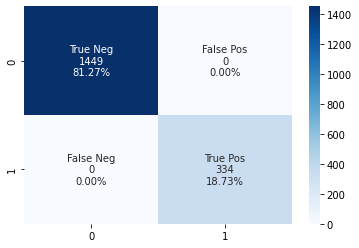

In [14]:
%matplotlib inline

inspector.display_interactive_cm()

---

Lastly, we're going to use the Snowflake Python connector to load our predictions into Snowflake to drive credit-risk analysis. This is only practical for smaller data sets. For larger data sets the Snowflake [COPY](https://docs.snowflake.com/en/sql-reference/sql/copy-into-table.html) command can be used to load data directly from S3.

In practice, the process of loading the predictions from S3 into Snowflake should be part of your production scoring pipeline. Snowflake provides a service called [Snowpipe](https://docs.snowflake.com/en/user-guide/data-load-snowpipe-intro.html) that autoamtically can load data from S3 to Snowflake and will automatically scale based on the data volume, with no manamgement required.

We already used the AWS Secrets Manager to store your Snowflake credentials. Go to the [Secrets Manager Console](https://console.aws.amazon.com/secretsmanager/home). Select the Snowflake Secret and copy the Secret Name i.e. <span style="color:lightgreen">**SnowflakeSecret-P4qyGUyk67hj**</span> in the cell below.  

In [34]:
secret_name = "SnowflakeSecret-P4qyGUyk67hj"

In [73]:
import base64
from botocore.exceptions import ClientError
import json


def get_secret():


    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region
    )

    # In this sample we only handle the specific exceptions for the 'GetSecretValue' API.
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    # We rethrow the exception by default.

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException':
            # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException':
            # An error occurred on the server side.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException':
            # You provided an invalid value for a parameter.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException':
            # You provided a parameter value that is not valid for the current state of the resource.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException':
            # We can't find the resource that you asked for.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
    else:
        # Decrypts secret using the associated KMS CMK.
        # Depending on whether the secret is a string or binary, one of these fields will be populated.
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
    return json.loads(secret)       
    # Your code goes here. 

In [82]:
import snowflake.connector
# Connecting to Snowflake using the default authenticator

# Get credentials from Secrets Manager 
snowcreds = get_secret()


ctx = snowflake.connector.connect(
  user=snowcreds["username"],
  password=snowcreds["password"],
  account=snowcreds["accountid"],
  warehouse='ML_WH',
  database='ML_LENDER_DATA',
  schema='ML_DATA'
)

In [107]:
from snowflake.connector.pandas_tools import write_pandas

# Write the predictions to the table named "ML_RESULTS".
success, nchunks, nrows, _ = write_pandas(ctx, results[cols], 'ML_RESULTS', quote_identifiers=False)

display(nrows)

1783

#### Clean up

Congratulations! You've completed the lab. You can delete the active resources created for the lab by deleting the CloudFormation templates. Also check for any S3 buckets that were created, empty them and delete the buckets.

Follow the steps in Snowflake Worksheet (SQL Script) to delete all Snowflake resources that were created.

